In [1]:
import itertools
import joblib
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

import yaml


# Config

In [2]:
%cd ..

/home/carolin/DVC/work/course-ds-base


In [53]:
with open("params.yaml") as conf_file:
    config = yaml.safe_load(conf_file)
print(config)

{'base': {'random_state': 42}, 'data': {'dataset_csv': 'data/raw/iris.csv', 'features_path': 'data/processed/featured_iris.csv', 'trainset_path': 'data/processed/train_iris.csv', 'testset_path': 'data/processed/test_iris.csv', 'test_size': 0.2}, 'train': {'clf_params': {'C': 0.001, 'solver': 'lbfgs', 'multi_class': 'multinomial', 'max_iter': 100}, 'model_path': 'models/model.joblib'}, 'reports': {'metrics_file': 'reports/metrics.json', 'confusion_matrix_image': 'reports/confusion_matrix.png'}}


# Load dataset

In [39]:
# Get data 

import pandas as pd
from sklearn.datasets import load_iris

data = load_iris(as_frame=True)
dataset = data.frame
dataset.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [40]:
# print labels for target values 

[print(f'{target}: {label}') for target, label in zip(data.target.unique(), data.target_names)]

0: setosa
1: versicolor
2: virginica


[None, None, None]

In [41]:
# feature names

dataset.columns = [colname.strip(' (cm)').replace(' ', '_') for colname in dataset.columns.tolist()]

feature_names = dataset.columns.tolist()[:4]
feature_names

['sepal_length', 'sepal_width', 'petal_length', 'petal_width']

In [42]:
# Save raw data

dataset.to_csv(config["data"]["dataset_csv"], index=False)

# Features engineering

In [43]:
dataset['sepal_length_to_sepal_width'] = dataset['sepal_length'] / dataset['sepal_width']
dataset['petal_length_to_petal_width'] = dataset['petal_length'] / dataset['petal_width']

dataset = dataset[[
    'sepal_length', 'sepal_width', 'petal_length', 'petal_width',
#     'sepal_length_in_square', 'sepal_width_in_square', 'petal_length_in_square', 'petal_width_in_square',
    'sepal_length_to_sepal_width', 'petal_length_to_petal_width',
    'target'
]]

In [44]:
dataset.head()

,sepal_length,sepal_width,petal_length,petal_width,sepal_length_to_sepal_width,petal_length_to_petal_width,target
0,5.1,3.5,1.4,0.2,1.457143,7.0,0
1,4.9,3.0,1.4,0.2,1.633333,7.0,0
2,4.7,3.2,1.3,0.2,1.468750,6.5,0
3,4.6,3.1,1.5,0.2,1.483871,7.5,0
4,5.0,3.6,1.4,0.2,1.388889,7.0,0


In [45]:
# Save features
# features_path = 'data/processed/featured_iris.csv'
dataset.to_csv(config["data"]["features_path"], index=False)

# Split dataset

In [48]:
#random_state = 42
# test_size = 0.2

train_dataset, test_dataset = train_test_split(dataset, test_size=config["data"]["test_size"], random_state=config["base"]["random_state"])
train_dataset.shape, test_dataset.shape

((120, 7), (30, 7))

In [49]:
# Save train and test sets

train_dataset.to_csv(config["data"]["trainset_path"])
test_dataset.to_csv(config["data"]["testset_path"])

# Train

In [50]:
# Get X and Y

y_train = train_dataset.loc[:, 'target'].values.astype('int32')
X_train = train_dataset.drop('target', axis=1).values.astype('float32')

In [51]:
# Create an instance of Logistic Regression Classifier CV and fit the datamax_iter': 100

logreg = LogisticRegression(**config["train"]["clf_params"], random_state=random_state)
logreg.fit(X_train, y_train)

LogisticRegression(C=0.001, multi_class='multinomial', random_state=42)

In [54]:
joblib.dump(logreg, config["train"]["model_path"])

['models/model.joblib']

# Evaluate

In [55]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    
    return plt.gcf()

In [56]:
# Get X and Y

y_test = test_dataset.loc[:, 'target'].values.astype('int32')
X_test = test_dataset.drop('target', axis=1).values.astype('float32')

In [57]:
prediction = logreg.predict(X_test)
cm = confusion_matrix(prediction, y_test)
f1 = f1_score(y_true = y_test, y_pred = prediction, average='macro')

In [58]:
# f1 score value
f1

0.9305555555555555

In [59]:
# Save metrics

metrics = {
    'f1': f1
}

with open(config["reports"]["metrics_file"], 'w') as mf:
    json.dump(
        obj=metrics,
        fp=mf,
        indent=4
    )

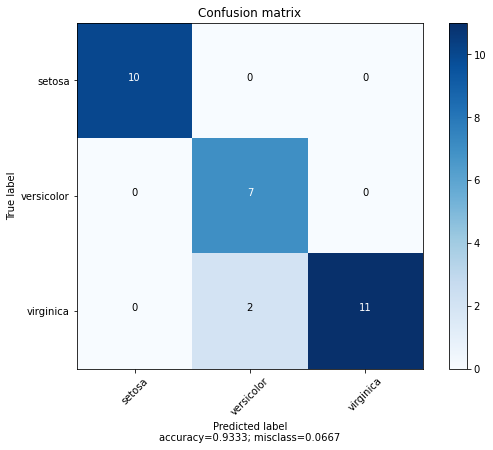

In [60]:
cm_plot = plot_confusion_matrix(cm, data.target_names, normalize=False)

In [61]:
# Save confusion matrix image
cm_plot.savefig(config["reports"]["confusion_matrix_image"])